# Sequence-to-Seqeunce

* https://wikidocs.net/24996

* Sequence-to-sequence(Seq2Seq)는 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 모델
* 예를 들어, 한국어 도메인을 가지는 문장을 입력해 중국어 도메인에 해당하는 문장을 얻을 수 있음
* Seq2Seq는 다른 특별한 기술을 이용하는 것이 아닌 지금까지 배운 RNN 기술들을 조합해 만들며, encoder와 decoder로 구성

# 기계 번역 데이터

* 일반적인 자연어 처리의 경우, 입력 시퀀스와 출력 시퀀스의 길이가 동일함
* Seq2Seq는 입력 시퀀스와 출력 시퀀스의 길이가 다를 수 있다고 가정
* Seq2Seq에는 인코더의 입력, 디코더의 입력, 디코더의 출력에 해당하는 데이터가 필요



* 데이터는 영어 문장과 그에 해당하는 프랑스어 문장이 존재하는 기계 번역 데이터를 사용
* url 주소에서 데이터를 받아오고, 필요없는 열(lic)은 제거



In [1]:
import os, shutil, urllib3, zipfile
import numpy as np
import pandas as pd

* http://www.manythings.org/anki/fra-eng.zip

In [2]:
http = urllib3.PoolManager()
url = 'http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'

with http.request('GET', url, preload_content=False) as r, open(filename, 'wb') as out_file:
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

In [3]:
lines = pd.read_csv('fra.txt', names=['src','tar','lic'], sep='\t')
del lines['lic']
len(lines)

194513

In [4]:
lines.head()

,src,tar
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


*   데이터를 모두 사용할 경우 많은 시간이 소요되기 때문에, 일부 데이터만 사용
*   목표 데이터에는 시작과 끝을 나타내는 토큰이 포함되어야 함
*   여기서는 '\t'와 '\n'을 각각 시작과 끝을 나타내는 토큰으로 사용

In [5]:
lines = lines.loc[:, 'src':'tar']
lines = lines[:50000]
lines.tar = lines.tar.apply(lambda x: '\t ' + x + ' \n')

lines.head()

,src,tar
0,Go.,\t Va ! \n
1,Go.,\t Marche. \n
2,Go.,\t Bouge ! \n
3,Hi.,\t Salut ! \n
4,Hi.,\t Salut. \n




*   해당 예제에서는 글자 단위로 예측, 따라서 글자 집합을 구축해주어야 함
*   구축한 다음, 정렬해 인덱스를 부여해 글자에 해당하는 사전을 만듬
*   사전은 글자를 모델에 투입하도록 변환하거나 예측시 반환되는 인덱스들을 글자로 변환할 때 사용



In [6]:
src_vocab = set()
for line in lines.src:
    for char in line:
        src_vocab.add(char)

tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [7]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))

src_vocab_size = len(src_vocab) + 1
tar_vocab_size = len(tar_vocab) + 1

src_to_idx = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_idx = dict([(word, i+1) for i, word in enumerate(tar_vocab)])

print(src_to_idx)
print(tar_to_idx)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, '’': 77, '€': 78}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 3

*   인코더에 입력될 입력 데이터를 구성
*   문장의 글자 하나씩을 사전을 이용해 인덱스로 변환해 리스트에 넣음



In [8]:
encoder_input = []
for line in lines.src:
    encoder_input.append([src_to_idx[w] for w in line])

print(encoder_input[:5])

[[30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10], [31, 58, 10]]




*   디코더에 입력될 입력 데이터를 구성
*   인코더 입력 데이터 처리와 동일하나, 목표 데이터에 해당하는 사전을 사용해주어야 함



In [9]:
decoder_input = []
for line in lines.tar:
    decoder_input.append([tar_to_idx[w] for w in line])

print(decoder_input[:5])

[[1, 3, 48, 52, 3, 4, 3, 2], [1, 3, 39, 52, 69, 54, 59, 56, 14, 3, 2], [1, 3, 28, 66, 72, 58, 56, 3, 4, 3, 2], [1, 3, 45, 52, 63, 72, 71, 3, 4, 3, 2], [1, 3, 45, 52, 63, 72, 71, 14, 3, 2]]



*   디코더의 출력과 비교할 목표 데이터를 구성
*   디코더의 입력 데이터를 구성할 때와 동일하나, 시작 토큰을 제외해주어야 함



In [10]:
decoder_target = []
for line in lines.tar:
    decoder_target.append([tar_to_idx[w] for w in line if w != '\t'])

print(decoder_target[:5])

[[3, 48, 52, 3, 4, 3, 2], [3, 39, 52, 69, 54, 59, 56, 14, 3, 2], [3, 28, 66, 72, 58, 56, 3, 4, 3, 2], [3, 45, 52, 63, 72, 71, 3, 4, 3, 2], [3, 45, 52, 63, 72, 71, 14, 3, 2]]




* 각각의 데이터를 동일한 길이로 맞춰줌
* 길이를 맞춰줄 때는 해당 데이터의 최대 길이로 맞춰줌
* 원 핫 인코딩을 통해 원 핫 벡터로 변환



In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_src_len = max(len(line) for line in lines.src)
max_tar_len = max(len(line) for line in lines.tar)

encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

In [12]:
from tensorflow.keras.utils import to_categorical

encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

## 인코더(Encoder)

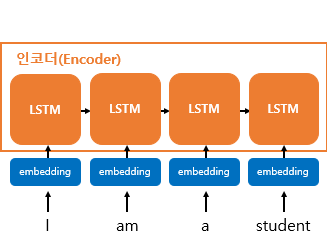



* encoder는 입력 문장을 받는 여러 개의 RNN cell
* 입력은 단어 토큰화로 단어 단위로 쪼개지고, 이는 각 시점의 encoder 입력이 됨
* encoder는 모든 단어를 입력받고 마지막 시점의 은닉 상태를 decoder RNN cell의 첫번째 은닉 상태로 넘겨주며, 
이를 컨텍스트 벡터(context vector)라고 함
* encoder는 입력 시퀀스를 컨텍스트 벡터라는 고정 길이 벡터로 압축하고자 함



## 인코더 모델 구성



*   encoder의 구성은 일반 lstm 모델과 동일
*   lstm 안의 return_state는 은닉 상태를 반환해줘 seq2seq 모델을 구성할 때 필요함



In [13]:
from tensorflow.keras.layers import Input, LSTM

encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(256, return_state=True)

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

## 디코더(Decoder)

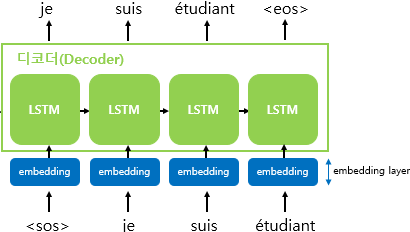

* decoder는 encoder와 마찬가지로 여러 개의 RNN cell로 이루어짐
* decoder의 처음 입력은 시작을 나타내는 토큰을 입력하며, 이 토큰 다음에 등장할 단어를 예측
* 처음 셀에서 단어를 예측한 결과는 다시 다음 시점의 decoder 입력으로 사용
* 위 과정을 반복해, 끝을 나타내는 토큰이 예측될 때까지 반복
* 요약하자면 decoder는 encoder에서 넘겨받은 컨텍스트 벡터를 활용해 시퀀스를 만들어 냄



### 교사 강요(Teacher Forcing)


* 앞서 설명한 seq2seq 모델을 잘 살펴보면 디코더의 입력이 필요하지 않음을 알 수 있음
* 예측이 잘못됐을 경우, 잘못된 예측이 다음 시점으로 입력돼 연쇄적으로 잘못된 예측을 함
* 이를 해결하기 위해 디코더의 다음 시점의 입력으로 이전 시점의 출력이 아닌, 정답을 주어 이를 방지함





## 디코더 모델 구성



*   모델의 구성은 encoder과 거의 유사함
*   lstm의 return_sequences는 출력을 시퀀스로 반환할 때 사용
*   decoder_lstm을 사용할 때는 initial_state를 인코더의 은닉 상태로 설정
*   마지막으로 Dense layer와 softmax를 통과해 예측 글자에 해당하는 인덱스를 반환



In [14]:
from tensorflow.keras.layers import Dense

decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(256, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

## Seq2Seq 모델



*   앞서 구성한 encoder와 decoder를 결합해 seq2seq model을 구성
*   구성한 모델과 준비한 데이터를 사용해 기계 번역 학습



In [15]:
from tensorflow.keras.models import Model

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile('rmsprop', 'categorical_crossentropy')

In [16]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target,
          batch_size=128, epochs=25, validation_split=0.2)

Epoch 1/25
313/313 [==============================] - 16s 27ms/step - loss: 0.9364 - val_loss: 0.7935
Epoch 2/25
313/313 [==============================] - 7s 22ms/step - loss: 0.5598 - val_loss: 0.6451
Epoch 3/25
313/313 [==============================] - 7s 23ms/step - loss: 0.4693 - val_loss: 0.5773
Epoch 4/25
313/313 [==============================] - 7s 23ms/step - loss: 0.4162 - val_loss: 0.5206
Epoch 5/25
313/313 [==============================] - 7s 23ms/step - loss: 0.3773 - val_loss: 0.4836
Epoch 6/25
313/313 [==============================] - 7s 23ms/step - loss: 0.3505 - val_loss: 0.4604
Epoch 7/25
313/313 [==============================] - 7s 23ms/step - loss: 0.3287 - val_loss: 0.4319
Epoch 8/25
313/313 [==============================] - 7s 23ms/step - loss: 0.3111 - val_loss: 0.4187
Epoch 9/25
313/313 [==============================] - 7s 23ms/step - loss: 0.2964 - val_loss: 0.4023
Epoch 10/25
313/313 [==============================] - 7s 23ms/step - loss: 0.2829 - val_l

## 예측



*   일반 모델과는 다르게, seq2seq 모델은 모델 예측 프로세스가 다름
*   예측할 때는 인덱스 하나씩을 예측하게 되며, 예측한 인덱스를 저장하고 이를 다시 입력으로 사용해 종료 토큰이 나올때까지 반복
*   마지막으로 예측한 인덱스들을 사전을 통해 글자들로 변환해 최종 예측을 얻음



In [17]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [18]:
decoder_state_input_h = Input(shape=(256))
decoder_state_input_c = Input(shape=(256))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]

decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                      outputs=[decoder_outputs] + decoder_states)

In [19]:
idx_to_src = dict((i, char) for char, i in src_to_idx.items())
idx_to_tar = dict((i, char) for char, i in tar_to_idx.items())

In [22]:
def predict_decode(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_idx['\t']] = 1

    stop = False
    decoded_sentence = ''

    while not stop:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx_to_tar[sampled_token_index]

        decoded_sentence += sampled_char
        if sampled_char == '\n' or len(decoded_sentence) > max_tar_len:
            stop = True

        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1
        states_value = [h, c]

    return decoded_sentence

In [26]:
for seq_index in [1, 11, 111, 1111]:
    input_seq = encoder_input[seq_index : seq_index+1]
    decoded_sentence = predict_decode(input_seq)

    print('입력:', lines.src[seq_index])
    print('정답:', lines.tar[seq_index][1:-1])
    print('번역:', decoded_sentence[:-1], '\n')

입력: Go.
정답:  Marche. 
번역:  Pars !  

입력: Run!
정답:  Fuyez ! 
번역:  Fais attention.  

입력: I lost.
정답:  J'ai perdu. 
번역:  J'ai senti.  

입력: I was new.
정답:  J'étais nouvelle. 
번역:  J'étais en train de parler.  

